In [2]:
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding=1)
        
    def forward(self, x):
        fx = self.conv1(x)
        fx = self.relu(fx)
        fx = self.conv2(fx)
        out = x + fx
        out = self.relu(out)
        
        return out



class EVSRNet(nn.Module):
    def __init__(self, scale_factor=4, input_shape=(3, None, None)):
        super(EVSRNet, self).__init__()
        self.scale_factor = scale_factor
        self.input_shape = input_shape
        
        self.conv1 = nn.Conv2d(in_channels=input_shape[0], out_channels=8, kernel_size=3, padding=1)
        self.res1 = ResidualBlock()
        self.res2 = ResidualBlock()
        self.res3 = ResidualBlock()
        self.res4 = ResidualBlock()
        self.res5 = ResidualBlock()
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=input_shape[0] * (scale_factor ** 2), kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.depth_to_space = nn.PixelShuffle(scale_factor)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)
        x = self.res4(x)
        x = self.res5(x)
        x = self.conv2(x)
        x = self.relu(x)
        out = self.depth_to_space(x)
        
        return out

In [1]:
import torch
torch.cuda.is_available()

True

In [64]:
import torch
import cv2

model = EVSRNet()
#model.load_state_dict(torch.load('C:/Users/MOBED/Omni_Ingest/Checkpoints/230306_5pm_loss0037.pth'))
model.load_state_dict(torch.load('C:/Users/MOBED/Omni_Ingest/Checkpoints/model.pth'))
model.eval()

EVSRNet(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (res1): ResidualBlock(
    (conv1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (res2): ResidualBlock(
    (conv1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (res3): ResidualBlock(
    (conv1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (res4): ResidualBlock(
    (conv1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (res5): ResidualBlock(
    (conv1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (r

In [63]:
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor, ToPILImage
from PIL import Image
import numpy as np

T2T = ToTensor() # numpy or PIL_Image to Tensor
T2P = ToPILImage() # Tensor to PIL_Image


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [10]:
## 백업용 train code
### 실제 실행 시켜야하는건 아래 수정한 train code
import os
from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio, structural_similarity


def train(model, model_name, scale, data_path, num_epochs=2, batch_size=4):
    os.makedirs("./Checkpoints/", exist_ok=True)
    before_loss = 100
    
    train_set = SRDataset(lr_root=data_path + "X{}/".format(scale), hr_root=data_path + "X1/")
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-6)
    criterion = torch.nn.MSELoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("device : ",device)
    model.to(device)
    
    for epoch in range(num_epochs):
        train_loss = 0
        model.train()        
        for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
            data, target = data.to(device), target.to(device)
            # print('data shape : ',data.shape) # (N x C X H X W)
            # print('data : ',data)
            # print('target shape : ',target.shape) # (N x C X H X W)
            # print('target : ',target)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch+1, train_loss/len(train_loader)))
        print("PSNR :", peak_signal_noise_ratio(output, target))
        print("SSIM :", structural_similarity(output, target, multichannel=True))
        if ((train_loss/len(train_loader)) <= before_loss):
            before_loss = train_loss/len(train_loader)
            torch.save(model.state_dict(), "./Checkpoints/{}.pth".format(model_name))

In [23]:
import os
from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio, structural_similarity


os.makedirs("./Checkpoints/", exist_ok=True)


def train(model, model_name, scale, data_path, num_epochs=2, batch_size=1):
    
    test_hr = cv2.imread(data_path)
    test_hr = cv2.cvtColor(test_hr,cv2.COLOR_BGR2RGB)
    test_hr = cv2.resize(test_hr,(480*4,270*4),interpolation=cv2.INTER_CUBIC)
    test_hr = test_hr.astype(np.float32)
    test_hr = test_hr / 255.
    test_lr = cv2.resize(test_hr,(480,270),interpolation=cv2.INTER_CUBIC)
    test_lr = torch.from_numpy(np.transpose(test_lr,(2,0,1))).float()
    test_hr = torch.from_numpy(np.transpose(test_hr,(2,0,1))).float()
    test_lr = torch.unsqueeze(test_lr,0)
    test_hr = torch.unsqueeze(test_hr,0)
    
    before_loss = 100
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.MSELoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("device : ",device)
    model.to(device)
    
    for epoch in tqdm(range(num_epochs)):
        train_loss = 0
        model.train()    
            
        test_lr, test_hr = test_lr.to(device), test_hr.to(device) # data = test_lr, target = test_hr
        # print('data shape : ',data.shape) # (N x C X H X W)
        # print('data : ',data)
        # print('target shape : ',target.shape) # (N x C X H X W)
        # print('target : ',target)
        optimizer.zero_grad()
        output = model(test_lr)
        loss = criterion(output, test_hr) # criterion(data, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    print('Training Loss: {:.8f}'.format(train_loss/num_epochs))
    mse = torch.mean((test_hr - output) ** 2)
    # PSNR 값 계산
    psnr = 10 * torch.log10(1 / mse)
    print("PSNR: ", psnr.item())    
    if ((train_loss/num_epochs) <= before_loss):
        before_loss = train_loss/num_epochs
        torch.save(model.state_dict(), "./Checkpoints/{}.pth".format(model_name))
        
    # output = torch.squeeze(output,0) # tensor(N x C x H x W) -> numpy(C x H x W)
    # output = T2P(output)
    # test_hr = torch.squeeze(test_hr,0) # tensor(N x C x H x W) -> numpy(C x H x W)
    # test_hr = T2P(test_hr)
    # plt.imshow(output)
    # plt.show()
    # plt.imshow(test_hr)
    # plt.show()

In [295]:
train(model, "evsrnet_t_x4", scale=4, data_path='C:/Users/MOBED/Pictures/Screenshots/test_frame1.png', num_epochs=10000, batch_size=1)

device :  cuda


100%|██████████| 10000/10000 [02:57<00:00, 56.44it/s]

Training Loss: 0.00000048


In [62]:
#count time for training
import time
start = time.time()
train(model, "evsrnet_t_x4", scale=4, data_path='C:/Users/MOBED/Omni_Ingest/Sample_data/desktop1.png', num_epochs=50, batch_size=1)
end = time.time()
print(f"Time: {(end-start):.6f} seconds")

device :  cuda


100%|██████████| 50/50 [00:00<00:00, 64.87it/s]

Training Loss: 0.00008634
PSNR:  23.648414611816406
Time: 0.810288 seconds


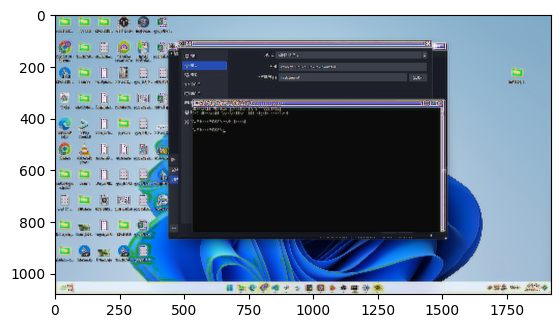

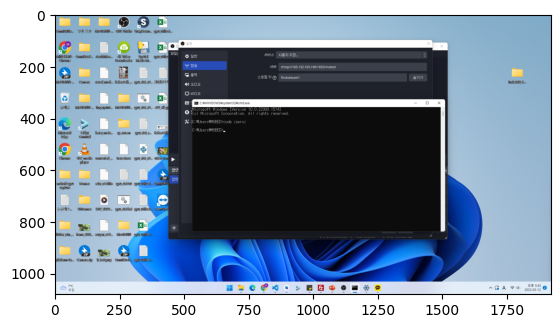

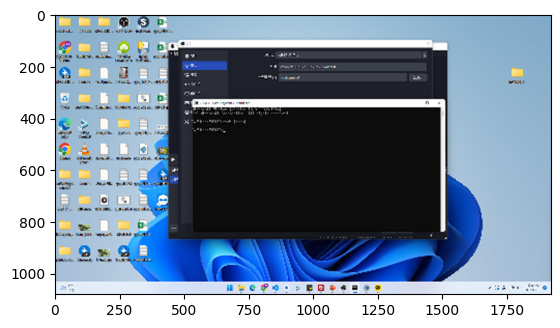

In [65]:
import cv2

# SR test function
lr_img = cv2.imread('C:/Users/MOBED/Omni_Ingest/Sample_data/desktop1.png')
lr_img = cv2.cvtColor(lr_img,cv2.COLOR_BGR2RGB)
test  = cv2.resize(lr_img,(480*4,270*4),interpolation=cv2.INTER_CUBIC) # dsize(width, height)

lr_img = cv2.resize(lr_img,(480,270),interpolation=cv2.INTER_CUBIC) # dsize(width, height)
bi_img  = cv2.resize(lr_img,(480*4,270*4),interpolation=cv2.INTER_CUBIC) # dsize(width, height)

lr_img = lr_img.astype(np.float32)
lr_img = lr_img / 255.
lr_img = torch.from_numpy(np.transpose(lr_img,(2,0,1))).float()
lr_img = torch.unsqueeze(lr_img,0) # numpy(C x H x W) -> tensor(N x C x H x W)
lr_img = lr_img.to(device)

model.eval()
model.to(device)
sr_img = model(lr_img)

sr_img = torch.squeeze(sr_img,0) # tensor(N x C x H x W) -> numpy(C x H x W)
sr_img = T2P(sr_img)

plt.imshow(sr_img)
plt.show()

plt.imshow(test)
plt.show()

plt.imshow(bi_img)
plt.show()

In [8]:
def train_w_img(model, model_name, scale, data, num_epochs=2, batch_size=1):
    
    test_hr = data
    test_hr = cv2.cvtColor(test_hr,cv2.COLOR_BGR2RGB)
    test_hr = cv2.resize(test_hr,(480*4,270*4),interpolation=cv2.INTER_CUBIC)
    test_hr = test_hr.astype(np.float32)
    test_hr = test_hr / 255.
    test_lr = cv2.resize(test_hr,(480,270),interpolation=cv2.INTER_CUBIC)
    test_lr = torch.from_numpy(np.transpose(test_lr,(2,0,1))).float()
    test_hr = torch.from_numpy(np.transpose(test_hr,(2,0,1))).float()
    test_lr = torch.unsqueeze(test_lr,0)
    test_hr = torch.unsqueeze(test_hr,0)
    
    before_loss = 100
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    criterion = torch.nn.MSELoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("device : ",device)
    model.to(device)
    
    for epoch in tqdm(range(num_epochs)):
        train_loss = 0
        model.train()    
            
        test_lr, test_hr = test_lr.to(device), test_hr.to(device) # data = test_lr, target = test_hr
        # print('data shape : ',data.shape) # (N x C X H X W)
        # print('data : ',data)
        # print('target shape : ',target.shape) # (N x C X H X W)
        # print('target : ',target)
        optimizer.zero_grad()
        output = model(test_lr)
        loss = criterion(output, test_hr) # criterion(data, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    if ((train_loss/num_epochs) <= before_loss):
        print('Training Loss: {:.8f}'.format(train_loss/num_epochs))
        before_loss = train_loss/num_epochs
        torch.save(model.state_dict(), "./Checkpoints/{}.pth".format(model_name))
        
    # output = torch.squeeze(output,0) # tensor(N x C x H x W) -> numpy(C x H x W)
    # output = T2P(output)
    # test_hr = torch.squeeze(test_hr,0) # tensor(N x C x H x W) -> numpy(C x H x W)
    # test_hr = T2P(test_hr)
    # plt.imshow(output)
    # plt.show()
    # plt.imshow(test_hr)
    # plt.show()

In [22]:
import cv2
from IPython.display import clear_output, display
from PIL import Image
import ipywidgets as widgets
import time

url = 'rtmp://165.132.105.190:1935/instest/firststream1'

# Open the video stream
cap = cv2.VideoCapture(url)

while True:
    # Read a frame from the video stream
    ret, frame = cap.read()

    if not ret:
        # Exit the loop if there is no frame
        break
    
    # Convert the frame from BGR to RGB format
    
    train_w_img(model, "evsrnet_t_x4", scale=4, data=frame, num_epochs=50, batch_size=1)
    
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB,)
    
    lr_frame = cv2.resize(frame,dsize=(480,270),interpolation=cv2.INTER_CUBIC)
    lr_frame = lr_frame.astype(np.float32)
    lr_frame = lr_frame / 255.
    lr_frame = torch.from_numpy(np.transpose(lr_frame,(2,0,1))).float()
    lr_frame = torch.unsqueeze(lr_frame,0) # numpy(C x H x W) -> tensor(N x C x H x W)
    lr_frame = lr_frame.to(device)

    model.eval()
    model.to(device)
    sr_frame = model(lr_frame)

    sr_frame = torch.squeeze(sr_frame,0) # tensor(N x C x H x W) -> numpy(C x H x W)
    sr_frame = T2P(sr_frame)
    
    # Display the frame
    clear_output(wait=True)
    # display(Image.fromarray(frame))
    display(sr_frame)
    # Wait for 0.5 seconds
    time.sleep(0.1)
    
# Release the video stream
cap.release() 

In [380]:
# -*- coding: utf-8 -*-
import numpy as np
import math

# 무작위 입력값과 결과값 생겅하기
x = np.linspace(-math.pi, math.pi, 2000)
y = np.sin(x)

# 가중치 무작위로 초기화하기
a = np.random.randn()
b = np.random.randn()
c = np.random.randn()
d = np.random.randn()

learning_rate = 1e-6
for t in range(2000):
    # 순전파 : 예측된 y 계산하기
    # y = a + b x + x^2 + d x^3
    y_pred = a + b * x + c * x ** 2 + d * x ** 3
    # 손실 계산하고 추력하기
    loss = np.square(y_pred - y).sum()
    if t % 100 == 99:
        print(t, loss)
        
    # 손실에 대한 a, b, c, d의 변화도를 계산하기 위한 역전파
    grad_y_pred = 2.0 * (y_pred - y)
    grad_a = grad_y_pred.sum()
    grad_b = (grad_y_pred * x).sum()
    grad_c = (grad_y_pred * x ** 2).sum()
    grad_d = (grad_y_pred * x ** 3).sum()
    
    # 가중치 갱신하기
    a -= learning_rate * grad_a
    b -= learning_rate * grad_b
    c -= learning_rate * grad_c
    d -= learning_rate * grad_d
    
print(f'Result: y = {a} + {b} x + {c} x^2 + {d} x^3')

99 652.122443960476
199 463.24560850928225
299 329.86324757477905
399 235.65492500847893
499 169.1072069369077
599 122.09325139445177
699 88.87574409869634
799 65.40369591085589
899 48.8163884852961
999 37.093377390995926
1099 28.8075017593909
1199 22.950554403538586
1299 18.810216667244575
1399 15.883169305136281
1499 13.813736254613376
1599 12.350552412118908
1699 11.315956777297092
1799 10.584371320541575
1899 10.067025783283803
1999 9.701164705977218
Result: y = -0.031351605055279334 + 0.8592575390473948 x + 0.005408673564995653 x^2 + -0.09368836712726356 x^3


In [3]:
import argparse
import asyncio
import json
import logging
import os
import ssl
import uuid

import cv2
import numpy as np
from aiohttp import web
from av import VideoFrame

from aiortc import MediaStreamTrack, RTCPeerConnection, RTCSessionDescription
from aiortc.contrib.media import MediaBlackhole, MediaPlayer, MediaRecorder, MediaRelay

ROOT = os.path.dirname(__file__)

logger = logging.getLogger("pc")
pcs = set()
relay = MediaRelay()


class VideoTransformTrack(MediaStreamTrack):
    """
    A video stream track that transforms frames from an another track.
    """

    kind = "video"

    def __init__(self, track, transform):
        super().__init__()  # don't forget this!
        self.track = track
        self.transform = transform

        # Create a named window
        cv2.namedWindow("Video", cv2.WINDOW_NORMAL)
        cv2.resizeWindow("Video", 480, 640)
    async def recv(self):
        frame = await self.track.recv()

        if self.transform == "cartoon":
            img = frame.to_ndarray(format="bgr24")
            
            # prepare color
            img_color = cv2.pyrDown(cv2.pyrDown(img))
            for _ in range(6):
                img_color = cv2.bilateralFilter(img_color, 9, 9, 7)
            img_color = cv2.pyrUp(cv2.pyrUp(img_color))

            # prepare edges
            img_edges = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            img_edges = cv2.adaptiveThreshold(
                cv2.medianBlur(img_edges, 7),
                255,
                cv2.ADAPTIVE_THRESH_MEAN_C,
                cv2.THRESH_BINARY,
                9,
                2,
            )
            img_edges = cv2.cvtColor(img_edges, cv2.COLOR_GRAY2RGB)

            # combine color and edges
            img = cv2.bitwise_and(img_color, img_edges)

            # rebuild a VideoFrame, preserving timing information
            new_frame = VideoFrame.from_ndarray(img, format="bgr24")
            new_frame.pts = frame.pts
            new_frame.time_base = frame.time_base
            
            # Display the frame using OpenCV
            cv2.imshow("Video", img)
            cv2.waitKey(1)
            
            return new_frame
        elif self.transform == "edges":
            # perform edge detection
            img = frame.to_ndarray(format="bgr24")
            img = cv2.cvtColor(cv2.Canny(img, 100, 200), cv2.COLOR_GRAY2BGR)

            # rebuild a VideoFrame, preserving timing information
            new_frame = VideoFrame.from_ndarray(img, format="bgr24")
            new_frame.pts = frame.pts
            new_frame.time_base = frame.time_base
            
            # Display the frame using OpenCV
            cv2.imshow("Video", img)
            cv2.waitKey(1)
            
            return new_frame
        elif self.transform == "rotate":
            # rotate image
            img = frame.to_ndarray(format="bgr24")
            rows, cols, _ = img.shape
            M = cv2.getRotationMatrix2D((cols / 2, rows / 2), frame.time * 45, 1)
            img = cv2.warpAffine(img, M, (cols, rows))

            # rebuild a VideoFrame, preserving timing information
            new_frame = VideoFrame.from_ndarray(img, format="bgr24")
            new_frame.pts = frame.pts
            new_frame.time_base = frame.time_base
            return new_frame
        else:
            img = frame.to_ndarray(format="bgr24")
            # img super resolution
            img = model(img)     
            cv2.imshow("Video", img)
            cv2.waitKey(1)
            
            new_frame = VideoFrame.from_ndarray(img, format="bgr24")
            new_frame.pts = frame.pts
            new_frame.time_base = frame.time_base
            return new_frame


async def index(request):
    content = open(os.path.join(ROOT, "index.html"), "r").read()
    return web.Response(content_type="text/html", text=content)


async def javascript(request):
    content = open(os.path.join(ROOT, "client.js"), "r").read()
    return web.Response(content_type="application/javascript", text=content)


async def offer(request):
    params = await request.json()
    offer = RTCSessionDescription(sdp=params["sdp"], type=params["type"])

    pc = RTCPeerConnection()
    pc_id = "PeerConnection(%s)" % uuid.uuid4()
    pcs.add(pc)

    def log_info(msg, *args):
        logger.info(pc_id + " " + msg, *args)

    log_info("Created for %s", request.remote)

    # prepare local media
    player = MediaPlayer(os.path.join(ROOT, "demo-instruct.wav"))
    if args.record_to:
        recorder = MediaRecorder(args.record_to)
    else:
        recorder = MediaBlackhole()

    @pc.on("datachannel")
    def on_datachannel(channel):
        # create image window
        cv2.namedWindow("Image", cv2.WINDOW_NORMAL)
        cv2.resizeWindow("Image", 480, 640)
        
        img_buf = b''
        img_size = 0
        
        @channel.on("message")
        def on_message(message):
            nonlocal img_buf, img_size
            # print("Message received: ", message)
            print("Type: ", type(message))
            
            if isinstance(message, str) and message.startswith("ping "):
                print("Received ping")
                channel.send("pong ")
            if isinstance(message, str) and message.startswith("size "):
                print("Received image size: ", message[5:])
                img_size = int(message[5:])
            if isinstance(message, bytes):

                if len(img_buf) < img_size:
                    img_buf += message
                    print('img_buf: ', len(img_buf))
                if len(img_buf) == img_size:
                    print('final img_buf: ', len(img_buf))
                    print('img_buf: ', img_buf)
                    print('img_buf type: ', type(img_buf))
                    img_np = np.frombuffer(img_buf, np.uint8)
                    print('img_np: ', img_np)
                    print('img_np type: ', type(img_np))
                    print('img_np len: ', len(img_np))
                    if len(img_np) == 640*480*4:
                        img_np = img_np.reshape(640, 480, 4)
                        img_np = cv2.cvtColor(img_np, cv2.COLOR_RGBA2BGR)
                        img_np = cv2.resize(img_np, (480, 640))
                        
                        # tflite weight update by image
                                                
                        cv2.imshow("Image", img_np)
                        cv2.waitKey(1)
                        img_buf = b''
                        img_size = 0


    @pc.on("connectionstatechange")
    async def on_connectionstatechange():
        log_info("Connection state is %s", pc.connectionState)
        if pc.connectionState == "failed":
            await pc.close()
            pcs.discard(pc)

    @pc.on("track")
    def on_track(track):
        log_info("Track %s received", track.kind)

        if track.kind == "audio":
            pc.addTrack(player.audio)
            recorder.addTrack(track)
        elif track.kind == "video":
            pc.addTrack(
                VideoTransformTrack(
                    relay.subscribe(track), transform=params["video_transform"]
                )
            )
            if args.record_to:
                recorder.addTrack(relay.subscribe(track))

        @track.on("ended")
        async def on_ended():
            log_info("Track %s ended", track.kind)
            await recorder.stop()

    # handle offer
    await pc.setRemoteDescription(offer)
    await recorder.start()

    # send answer
    answer = await pc.createAnswer()
    await pc.setLocalDescription(answer)

    return web.Response(
        content_type="application/json",
        text=json.dumps(
            {"sdp": pc.localDescription.sdp, "type": pc.localDescription.type}
        ),
    )


async def on_shutdown(app):
    # close peer connections
    coros = [pc.close() for pc in pcs]
    await asyncio.gather(*coros)
    pcs.clear()


if __name__ == "__main__":
    parser = argparse.ArgumentParser(
        description="WebRTC audio / video / data-channels demo"
    )
    parser.add_argument("--cert-file", help="SSL certificate file (for HTTPS)")
    parser.add_argument("--key-file", help="SSL key file (for HTTPS)")
    parser.add_argument(
        "--host", default="0.0.0.0", help="Host for HTTP server (default: 0.0.0.0)"
    )
    parser.add_argument(
        "--port", type=int, default=8080, help="Port for HTTP server (default: 8080)"
    )
    parser.add_argument("--record-to", help="Write received media to a file."),
    parser.add_argument("--verbose", "-v", action="count")
    args = parser.parse_args()

    if args.verbose:
        logging.basicConfig(level=logging.DEBUG)
    else:
        logging.basicConfig(level=logging.INFO)

    if args.cert_file:
        ssl_context = ssl.SSLContext()
        ssl_context.load_cert_chain(args.cert_file, args.key_file)
    else:
        ssl_context = None

    app = web.Application()
    app.on_shutdown.append(on_shutdown)
    app.router.add_get("/", index)
    app.router.add_get("/client.js", javascript)
    app.router.add_post("/offer", offer)
    web.run_app(
        app, access_log=None, host=args.host, port=args.port, ssl_context=ssl_context
    )


usage: ipykernel_launcher.py [-h] [--verbose]
                             [--signaling {copy-and-paste,tcp-socket,unix-socket}]
                             [--signaling-host SIGNALING_HOST]
                             [--signaling-port SIGNALING_PORT]
                             [--signaling-path SIGNALING_PATH]
                             {offer,answer}
ipykernel_launcher.py: error: the following arguments are required: role


SystemExit: 2

c:\Users\MOBED\anaconda3\envs\torch113\lib\site-packages\IPython\core\interactiveshell.py:3468: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
